In [2]:
%pip install matplotlib
%pip install ultralytics

import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
%pwd


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'/Users/amy/code/homeplate/homeplate/python'

ORIGINAL: Image Width 4000 Height 2252
RESIZED: Image Width 4000 Height 2252


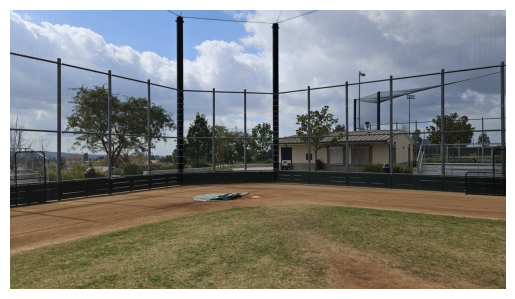

Max values - B: 255.0, G: 255.0, R: 255.0


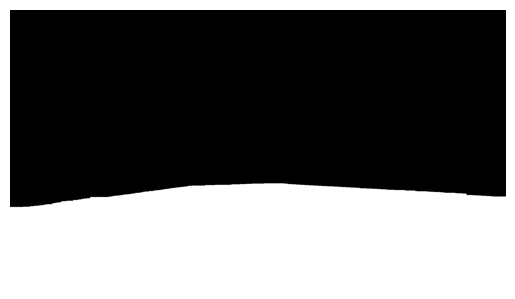

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [12]:
""" My directory has a list of images in ../images/ with format test0.jpg. 
    This method will load the image given the index in BGR format, and resize 
    it to be 4000 pixels in width.  """
def get_resized_image_from_image_index(index=0):
    image_path = f'../images/test{index}.jpg'
    mat_bgr = cv2.imread(image_path)
    print(f"ORIGINAL: Image Width {mat_bgr.shape[1]} Height {mat_bgr.shape[0]}")
    
    scale = 4000 / mat_bgr.shape[1]
    mat_bgr = cv2.resize(mat_bgr, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    print(f"RESIZED: Image Width {mat_bgr.shape[1]} Height {mat_bgr.shape[0]}")

    return mat_bgr

def show_bgr_image(bgr_image):
    """ Using matplotlib to display the image. Because it needs an RGB image, we 
    need to convert the given BGR image into an RGB image to show. """
    im_rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off') 
    plt.show()

def apply_hsv_filter(mat_bgr, lower_bound=np.array([10, 20, 80]), upper_bound=np.array([30, 255, 255])): 
    hsv_frame = cv2.cvtColor(mat_bgr, cv2.COLOR_BGR2HSV)
    # H, S, V 
    # Lower saturation captures more muted colors 
    # Higher values captures brighter shades 
    hsv_frame = cv2.inRange(hsv_frame, lower_bound, upper_bound)
    mat_bgr = cv2.resize(hsv_frame, None, fx=0.5, fy=0.5)

    # mat_bgr = cv2.cvtColor(mat_bgr, cv2.COLOR_HSV2BGR)
    return mat_bgr


""" Taking the brightest pixel and scaling the color space proportionally such that 
    that pixel is purely white. """
def get_white_balanced_image(image):
    image = image.astype(np.float32)

    b, g, r = cv2.split(image)
    
    max_b, max_g, max_r = np.max(b), np.max(g), np.max(r)
    print(f"Max values - B: {max_b}, G: {max_g}, R: {max_r}")

    b = b * (255.0 / max_b)
    g = g * (255.0 / max_g)
    r = r * (255.0 / max_r)

    balanced_image = cv2.merge([b, g, r])
    balanced_image = np.clip(balanced_image, 0, 255).astype(np.uint8)

    return balanced_image

""" Given a BGR image, output a mask with the foreground separated out """
def detect_foreground_from_image(image):
    image = get_white_balanced_image(image)
    binary_image = apply_hsv_filter(image, lower_bound=np.array([10,60,60]), upper_bound=np.array([60,255,255]))
    # show_bgr_image(image)
    # show_bgr_image(hsv_image)
    kernel = np.ones((25, 25), np.uint8) 


    # Perform morphological closing to fill gaps
    kernel = np.ones((10, 10), np.uint8)  # Adjust kernel size as needed
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)


    # Perform connected component analysis to identify the two largest regions
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)

    # Identify the two largest components (excluding the background)
    sorted_indices = np.argsort(stats[:, cv2.CC_STAT_AREA])[::-1]  # Sort by area
    largest_labels = sorted_indices[1:3]  # The two largest foreground components

    # Create a mask with only the two largest connected components (foreground and background)
    filtered_mask = np.zeros_like(binary_image)
    for label in largest_labels:
        filtered_mask[labels == label] = 255
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Excluding background label (0)
    largest_component_mask = np.where(labels == largest_label, 255, 0).astype(np.uint8)


    kernel = np.ones((100, 100), np.uint8)
    filled_mask = cv2.morphologyEx(largest_component_mask, cv2.MORPH_CLOSE, kernel)

        
    # show_bgr_image(binary_image)
    show_bgr_image(filled_mask)
    return filled_mask

# Call the method


mat_bgr = get_resized_image_from_image_index(0)
show_bgr_image(mat_bgr)
detect_foreground_from_image(mat_bgr)

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time


def custom_home_plate_find(image_path):
    print(f"FileName {image_path}")
    mat_bgr = cv2.imread(image_path)
    
    if mat_bgr is None or mat_bgr.size == 0:
        print("NOT OPENED")
        return
    scale = 4000 / mat_bgr.shape[1]
    mat_bgr = cv2.resize(mat_bgr, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    print(f"OPENED cols: {mat_bgr.shape[1]} rows: {mat_bgr.shape[0]}")
    
    start_ms = int(time.time() * 1000)

    hsv_value = custom_process_light_index_hsv_value_baseball(mat_bgr)
    # if hsv_value < 160:
    #     hsv_value = 160
    
    home_plate_image = find_home_plate(mat_bgr, mat_bgr, hsv_value)
    end_ms = int(time.time() * 1000)
    print(f'Took {end_ms - start_ms} ms')

    plt.imshow(home_plate_image)
    plt.title("Found Blobs")
    plt.show()

def custom_home_plate_find_with_ground_filter(image_path):
    print(f"FileName {image_path}")
    mat_bgr = cv2.imread(image_path)
    
    if mat_bgr is None or mat_bgr.size == 0:
        print("NOT OPENED")
        return
    scale = 4000 / mat_bgr.shape[1]
    
    mat_bgr = cv2.resize(mat_bgr, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    mask = detect_foreground_from_image(mat_bgr)
    mask = mask.astype(np.uint8)
    mask = cv2.resize(mask, (mat_bgr.shape[1], mat_bgr.shape[0]))
    
    filtered_mat_bgr = cv2.bitwise_and(mat_bgr, mat_bgr, mask=mask)

    print(f"OPENED cols: {mat_bgr.shape[1]} rows: {mat_bgr.shape[0]}")
    
    start_ms = int(time.time() * 1000)

    hsv_value = custom_process_light_index_hsv_value_baseball(mat_bgr)
    # if hsv_value < 160:
    #     hsv_value = 160
    
    home_plate_image = find_home_plate(mat_bgr, filtered_mat_bgr, hsv_value)
    end_ms = int(time.time() * 1000)
    print(f'Took {end_ms - start_ms} ms')

    plt.imshow(home_plate_image)
    plt.title("Found Blobs")
    plt.show()


def find_home_plate(original_mat_bgr, mat_bgr, hsv_value):
    min_area = 300
    
    print(f"Image Width: {mat_bgr.shape[1]} Height: {mat_bgr.shape[0]}")
    
    # if mat_bgr.shape[1] < 2600:
    #     mat_bgr = cv2.resize(mat_bgr, (0, 0), fx=2, fy=2)
    #     min_area //= 2
    
    hsv_frame = cv2.cvtColor(mat_bgr, cv2.COLOR_BGR2HSV)
    
    lower_bound = np.array([0, 25, hsv_value])
    upper_bound = np.array([30, 70, 255])
    
    mask = cv2.inRange(hsv_frame, lower_bound, upper_bound)
    kernel = np.ones((2, 2), np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    
    mask = cv2.bitwise_not(mask)
    
    resized_image = cv2.resize(mask, (0, 0), fx=0.5, fy=0.5)
    plt.imshow(resized_image, cmap='gray')
    plt.title("Thresholded")
    plt.show()
    
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = min_area
    params.filterByCircularity = True
    params.minCircularity = 0.15
    params.maxCircularity = 0.40
    params.filterByConvexity = True
    params.minConvexity = 0.85
    params.maxConvexity = 1.0
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(mask)
    
    print(f"Keypoints found: {len(keypoints)}")
    
    keypoint_list = [kp for kp in keypoints if verify_home_plate(mask, kp)]
    
    for kp in keypoint_list:
        print(f"Keypoint found size: {kp.size} x {kp.pt[0]} y {kp.pt[1]}")
    
    image_with_keypoints = cv2.drawKeypoints(original_mat_bgr, keypoints, None, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints = cv2.resize(image_with_keypoints, (0, 0), fx=0.5, fy=0.5)
    return cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    # plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    # plt.title("Found Blobs")
    # plt.show()

def custom_process_light_index_hsv_value_baseball(mat_bgr):
    if mat_bgr.shape[1] < 2600:
        print("Too small")
        return
    #     mat_bgr = cv2.resize(mat_bgr, (0, 0), fx=2, fy=2)
    mat_bgr_roi = mat_bgr[1800:mat_bgr.shape[0], 800:1600]
    mat_hsv = cv2.cvtColor(mat_bgr_roi, cv2.COLOR_BGR2HSV)
    

    hist = cv2.calcHist([mat_hsv], [2], None, [256], [0, 256])
    hist = hist / hist.max() * 100
    
    value_index = 200
    for i in range(256):
        if hist[i] >= 98:
            value_index = i
            break
    
    print(f"Index where value is 98: {value_index}")
    return value_index + 10

def verify_home_plate(image, keypoint):
    gray = image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        
        if len(approx) == 4:
            area = cv2.contourArea(contour)
            if area > 300:
                rect = cv2.boundingRect(approx)
                cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 4)
                print(f"Rectangle found, area {area}")
                print(f"Rectangle width: {rect[2]} height: {rect[3]}")
                if rect[2] > rect[3]:
                    print("*** Rectangle width > height")
    
    return True



FileName ../images/test1.jpg
OPENED cols: 4000 rows: 2667
Index where value is 98: 179
Image Width: 4000 Height: 2667


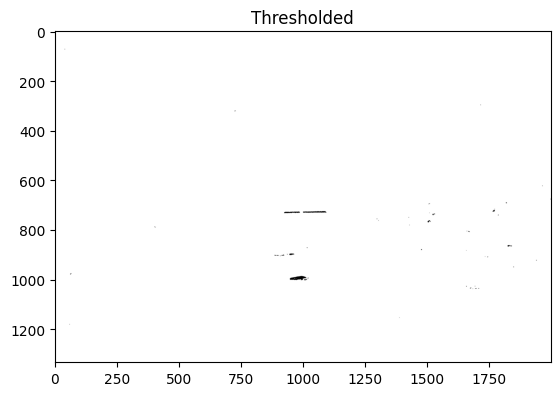

Keypoints found: 0
Took 245 ms


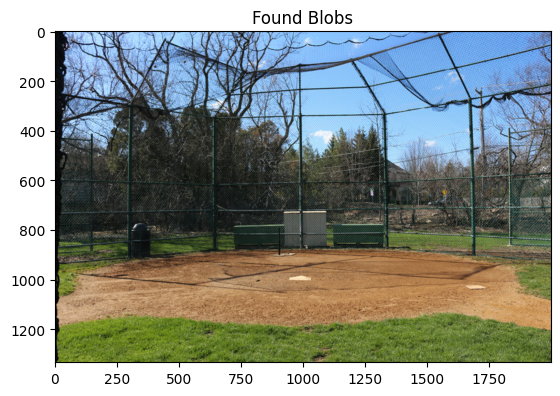

In [50]:
custom_home_plate_find('../images/test1.jpg')


FileName ../images/test1.jpg
Max values - B: 255.0, G: 255.0, R: 255.0


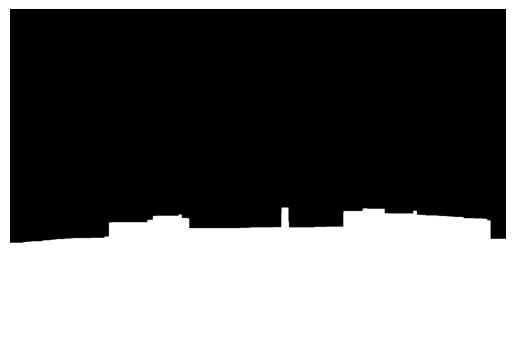

OPENED cols: 4000 rows: 2667
Index where value is 98: 179
Image Width: 4000 Height: 2667


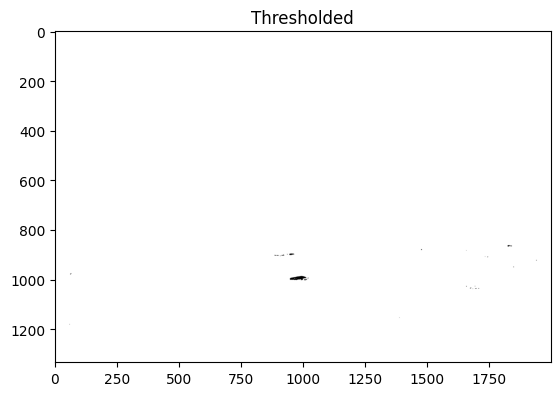

Keypoints found: 0
Took 205 ms


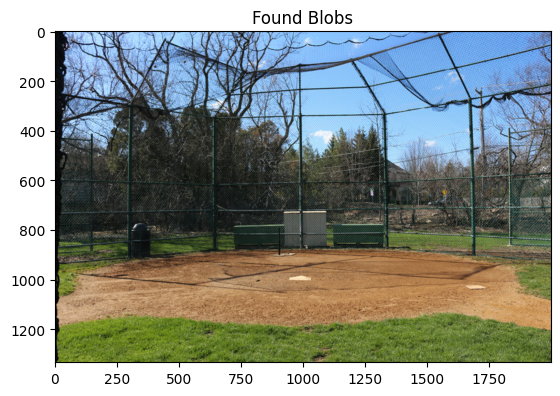

In [51]:
custom_home_plate_find_with_ground_filter('../images/test1.jpg')


FileName ../images/test4.jpg
OPENED cols: 4000 rows: 2221
Index where value is 98: 153
Image Width: 4000 Height: 2221


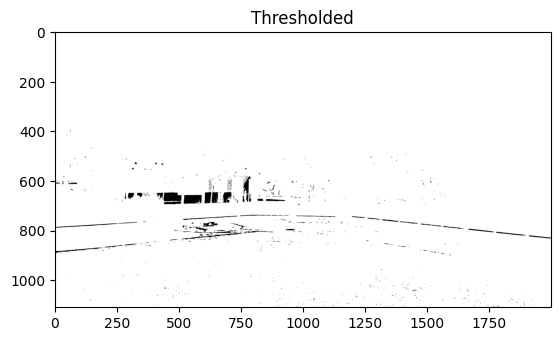

Keypoints found: 2
Rectangle found, area 619.0
Rectangle width: 100 height: 14
*** Rectangle width > height
Rectangle found, area 625.5
Rectangle width: 76 height: 12
*** Rectangle width > height
Rectangle found, area 4207.0
Rectangle width: 54 height: 91
Keypoint found size: 47.63013458251953 x 609.1657104492188 y 1322.0352783203125
Keypoint found size: 71.26870727539062 x 1285.913818359375 y 1338.27587890625
Took 207 ms


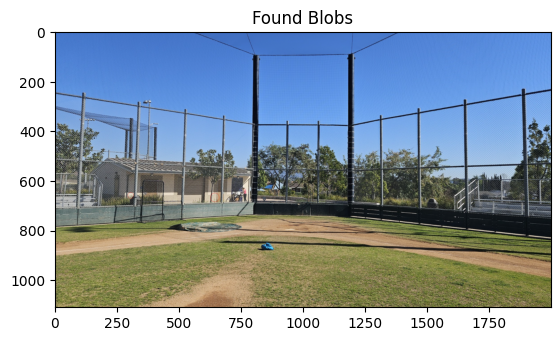

In [52]:
custom_home_plate_find('../images/test4.jpg')


FileName ../images/test11.jpg
OPENED cols: 4000 rows: 2348
Index where value is 98: 213
Image Width: 4000 Height: 2348


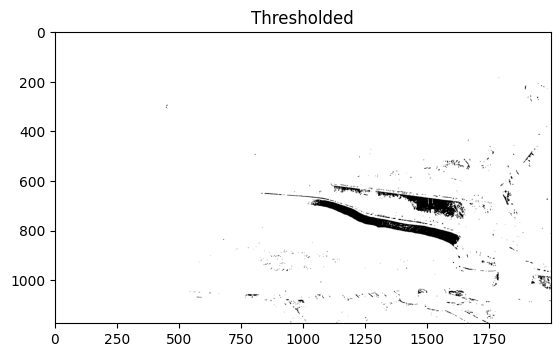

Keypoints found: 1
Keypoint found size: 35.81983947753906 x 3267.87060546875 y 1475.770263671875
Took 366 ms


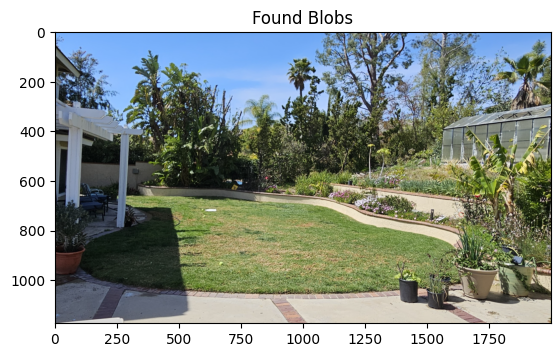

In [55]:
custom_home_plate_find('../images/test11.jpg')


FileName ../images/test11.jpg
Max values - B: 255.0, G: 255.0, R: 255.0


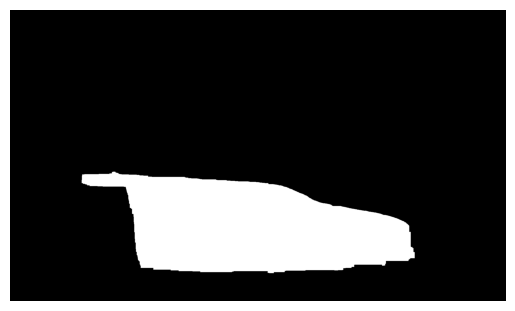

OPENED cols: 4000 rows: 2348
Index where value is 98: 213
Image Width: 4000 Height: 2348


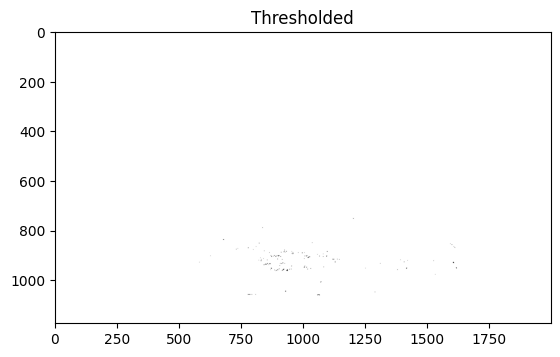

Keypoints found: 0
Took 206 ms


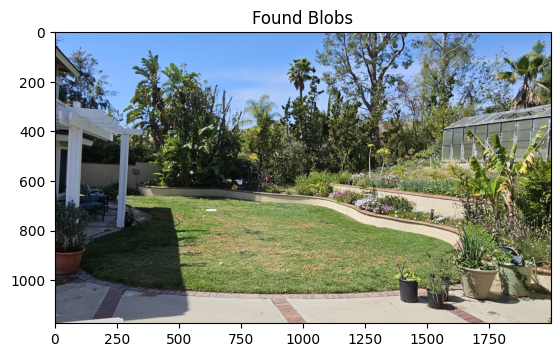

In [56]:
custom_home_plate_find_with_ground_filter('../images/test11.jpg')
